<a href="https://colab.research.google.com/github/eugeneteoh/COMP6248-Deep-Learning/blob/master/lab_4/exercise/lab4ex.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [7]:
%load_ext autoreload
%autoreload 2
# Load the TensorBoard notebook extension
%load_ext tensorboard

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [8]:
import torch
import torch.nn.functional as F
import torchvision.transforms as transforms
from torch import nn
from torch import optim
from torch.utils.data import DataLoader
from torchvision.datasets import MNIST

try:
    import pytorch_lightning as pl
except:
    !pip install pytorch-lightning
    import pytorch_lightning as pl
from pytorch_lightning import Trainer

import numpy as np
import matplotlib.pyplot as plt

torch.manual_seed(0)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
np.random.seed(0)

In [9]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print('Using {} device'.format(device))

Using cuda device


## Loading the MNIST data

In [10]:
# flatten 28*28 images to a 784 vector for each image
transform = transforms.Compose([
    transforms.ToTensor(),  # convert to tensor
    transforms.Lambda(lambda x: x.view(-1))  # flatten into vector
])

In [11]:
trainset = MNIST(".", train=True, download=True, transform=transform)
testset = MNIST(".", train=False, download=True, transform=transform)

In [12]:
# create data loaders
trainloader = DataLoader(trainset, batch_size=128, shuffle=True)
testloader = DataLoader(testset, batch_size=128)

## Defining the MLP model

In [13]:
# define baseline model
class BaselineModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super(BaselineModel, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size) 
        self.fc2 = nn.Linear(hidden_size, num_classes)  
    
    def forward(self, x):
        out = self.fc1(x)
        out = F.relu(out)
        out = self.fc2(out)
        if not self.training:
            out = F.softmax(out, dim=1)
        return out

## Training and Evaluating the Model


In [14]:
def train_model(model):
    # define the loss function and the optimiser
    loss_function = nn.CrossEntropyLoss()
    optimiser = optim.Adam(model.parameters())

    train_loss = torch.empty(10).to(device)
    train_acc = torch.empty(10).to(device)

    test_loss = torch.empty(10).to(device)
    test_acc = torch.empty(10).to(device)

    # the epoch loop
    for epoch in range(10):
        running_loss = 0.0
        acc = 0.0
        for data in trainloader:
            model.train()
            # get the inputs
            inputs, labels = data
            inputs = inputs.to(device)
            labels = labels.to(device)

            # zero the parameter gradients
            optimiser.zero_grad()

            # forward + loss + backward + optimise (update weights)
            outputs = model(inputs)
            loss = loss_function(outputs, labels)
            loss.backward()
            optimiser.step()

            # keep track of the loss this epoch
            running_loss += loss.item()
            
            # eval accuracy
            model.eval()
            with torch.no_grad():
                outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            acc += (preds == labels).sum()
            

        acc /= len(trainloader.dataset)
        running_loss /= len(trainloader)

        train_loss[epoch] = running_loss
        train_acc[epoch] = acc

        
        # test evaluation
        model.eval()
        with torch.no_grad():
            running_loss = 0.0
            acc = 0.0
            for data in testloader:
                inputs, labels = data
                inputs = inputs.to(device)
                labels = labels.to(device)

                outputs = model(inputs)
                _, preds = torch.max(outputs, 1)
            
                loss = F.nll_loss(torch.log(outputs), labels)

                acc += (preds == labels).sum()
                running_loss += loss.item()

            acc /= len(testloader.dataset)
            running_loss /= len(testloader)

            test_loss[epoch] = running_loss
            test_acc[epoch] = acc

        print(f"Epoch {epoch}, train loss {train_loss[epoch]}, train accuracy {train_acc[epoch]}, test loss {test_loss[epoch]}, test accuracy {test_acc[epoch]}")


    print('**** Finished Training ****')

    return train_loss.cpu().numpy(), train_acc.cpu().numpy(), test_loss.cpu().numpy(), test_acc.cpu().numpy()


In [ ]:
model_list = []
train_loss_list = []
train_acc_list = []
test_loss_list = []
test_acc_list = []

for hidden_size in [1000, 5000, 10000, 20000, 50000]:
    print(f"hidden_size = {hidden_size}")
    model = BaselineModel(784, hidden_size, 10).to(device)
    train_loss, train_acc, test_loss, test_acc = train_model(model)

    model_list.append(model)
    train_loss_list.append(train_loss)
    train_acc_list.append(train_acc)
    test_loss_list.append(test_loss)
    test_acc_list.append(test_acc)
    print("\n")

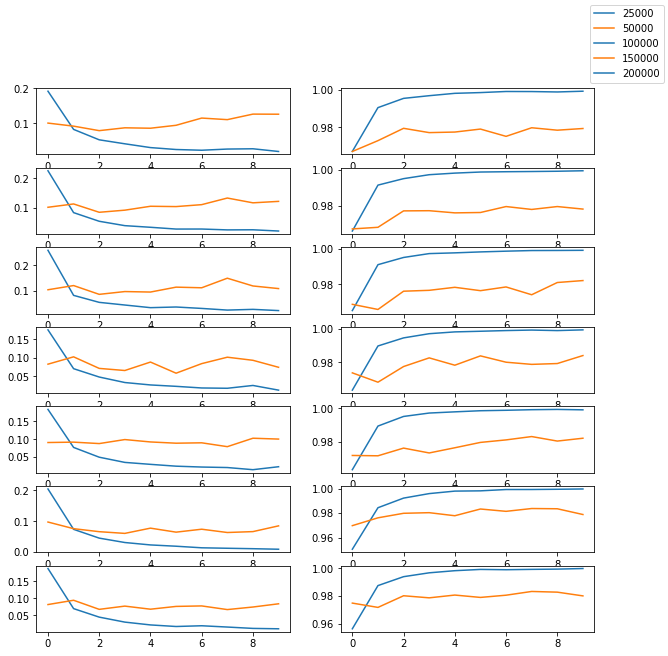

In [22]:
fig, ax = plt.subplots(len(model_list), 2, figsize=(10, 10))
for i in range(len(model_list)):
    ax[i, 0].plot(train_loss_list[i])
    ax[i, 0].plot(test_loss_list[i])
    ax[i, 1].plot(train_acc_list[i])
    ax[i, 1].plot(test_acc_list[i])

fig.legend([25000 ,50000, 100000, 150000, 200000])

In [17]:
plt.plot(train_loss.cpu())

AttributeError: ignored